In [1]:
# Modules import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn import metrics

# Settings
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
sns.set(style="white")

In [47]:
# Import data (we will immideatly merge some informaton together)
items              = pd.read_csv('./readonly/items.csv').set_index('item_id')
sales_train        = pd.read_csv('./readonly/sales_train.csv').join(items['item_category_id'], on='item_id') 
test               = pd.read_csv('./readonly/test.csv').join(items['item_category_id'], on='item_id')
item_categories    = pd.read_csv('./readonly/item_categories.csv').set_index('item_category_id')
shops              = pd.read_csv('./readonly/shops.csv').set_index('shop_id')

assert not sales_train['item_category_id'].isna().any()
assert not test['item_category_id'].isna().any()

# 1.Outliers
## 1.1 Every day sales
Lets consider what is hapenning with the value, which forms our target value. First idea is to watch a destribution plot and understand what happens with outliers.

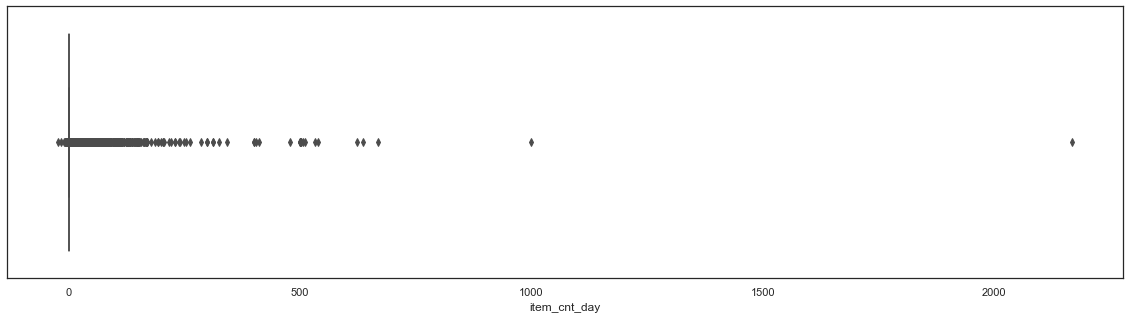

In [3]:
fig = plt.figure(figsize=(20, 5))
sns.boxplot(sales_train['item_cnt_day'])
plt.show()

According to the destribution there are sertain outliers. Let's dig into them and try to find any trends. We will separate whole dataset into 3 groups: negative values, "proper", "improper". ***nI*** (number of inclusions) is chosen as a parameter of separation by "item_cnt_day" as there are few unique values this column.

In [4]:
# Separate rows with negative values
negative_rows = sales_train[sales_train['item_cnt_day'] < 0]

# Check if some sertain shops have tendency for mistakes
print(len(negative_rows['shop_id'].unique()), "from", len(shops.index), "shops have mistakes with negative values")

for mistakes_threshold in [0.015, 0.01, 0.005]:
    many_mistakes = sales_train.groupby('shop_id').size().loc[
        negative_rows.groupby('shop_id').size() / sales_train.groupby('shop_id').size() > mistakes_threshold].index

    if (many_mistakes.size == 0):
        print("No shops have mistakes in more than", mistakes_threshold*100, "% of records")
    else:
        print("shops with ids", *many_mistakes, "have mistakes in more than", mistakes_threshold*100, "% of records")

54 from 60 shops have mistakes with negative values
No shops have mistakes in more than 1.5 % of records
shops with ids 12 have mistakes in more than 1.0 % of records
shops with ids 12 36 43 have mistakes in more than 0.5 % of records


Two possible solutions can be seen: include this negatives as values with the right sign or not to include them at all. Let's try the first approach.

In [5]:
# Apply "abs" function
sales_train.loc[:, 'item_cnt_day'] = sales_train['item_cnt_day'].apply(abs)

What about positive outliers?

In [6]:
# Let "counts" be a table in which every unique value of "item_cnt_day" column has a it's nI in data.
# Then let's take the i-th maximum nI and separate values of "count" table by this threshold.
# "proper_sales" dataframe will only include rows with "item_cnt_day" values, which nI is not less then threshold
i = 6

counts = sales_train['item_cnt_day'].value_counts().sort_values(ascending=False)
unique_counts_values = counts.unique()
threshold = unique_counts_values[min(i - 1, len(unique_counts_values) - 1)]

proper_values = counts[counts >= threshold].index
proper_sales = sales_train[sales_train['item_cnt_day'].isin(proper_values)]

improper_sales = sales_train.drop(proper_sales.index)

assert proper_sales.shape[0] + improper_sales.shape[0] == sales_train.shape[0], "Wrong sizes"

In [7]:
print("\"proper\" part of data consist of rows with values", *proper_sales['item_cnt_day'].sort_values().unique())

"proper" part of data consist of rows with values 1.0 2.0 3.0 4.0 5.0 6.0


In [8]:
topn = 10
print('From top', topn, 'items by inclusions in \"improper\" items meet in \"test\" part of data:')
for i in improper_sales['item_id'].value_counts().sort_values(ascending=False).index[:topn]:
    if i in test['item_id'].unique():
        print(i, ' (', improper_sales['item_id'].value_counts().sort_values(ascending=False)[i], ' inclusions) - ',
              item_categories.loc[items.loc[i]['item_category_id']]['item_category_name'], ' - ',
              items.loc[i]['item_name'],
              sep='')

From top 10 items by inclusions in "improper" items meet in "test" part of data:
20949 (7962 inclusions) - Подарки - Сумки, Альбомы, Коврики д/мыши - Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм
2808 (338 inclusions) - Игры PC - Стандартные издания - Diablo III [PC, Jewel, русская версия]
3732 (310 inclusions) - Игры - PS3 - Grand Theft Auto V [PS3, русские субтитры]
11370 (257 inclusions) - Доставка товара - Доставка (по Москве)
3731 (226 inclusions) - Игры PC - Стандартные издания - Grand Theft Auto V [PC, русские субтитры]
3734 (212 inclusions) - Игры - XBOX 360 - Grand Theft Auto V [Xbox 360, русские субтитры]
3331 (181 inclusions) - Игры PC - Стандартные издания - FIFA 14 [PC, русская версия]
6675 (178 inclusions) - Игровые консоли - PS4 - Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1108A/B01)


What can we see is the separation between products: games and 1C's special gifts are popular and can be bought many times per day. Let's see month's graphics of sales for some items to understand if there is a trend or games are bought many times only on release.

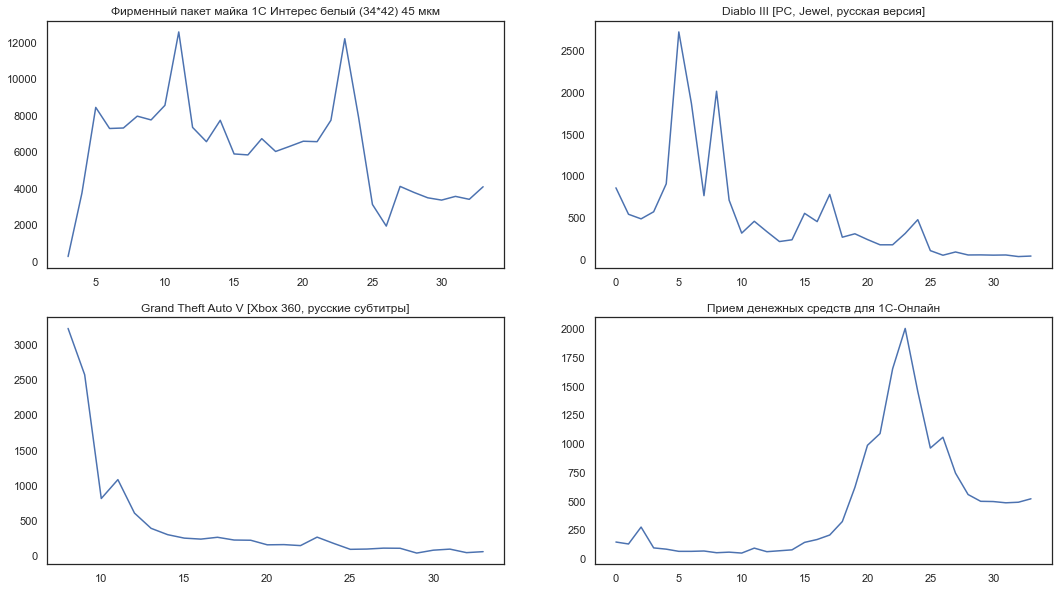

In [9]:
# Choose come interesting items
consider_items = [20949, 2808, 3734, 17717]

plt.subplots(len(consider_items) // 2, 2, figsize=(18, 5*len(consider_items) // 2))
subplot_id = 1

for item_id in consider_items:
    plt.subplot(len(consider_items) / 2, 2, subplot_id)
    subplot_id += 1
    plt.title(items.loc[item_id]['item_name'])
    plt.plot(sales_train[sales_train['item_id'] == item_id].groupby('date_block_num')['item_cnt_day'].sum())

As we can see, sales of games drop rapidly after release. Let's check if any new games are going to release in 34-th month

In [10]:
# Let's find new games (index are found in "item_categories")
new_releases_categories = [19, 20, 23, 24, 29, 30]
test_items_not_met_in_train = test[test['item_id'].isin(sales_train['item_id'].unique()) == False]
print(len(test_items_not_met_in_train[test_items_not_met_in_train['item_category_id'].isin(new_releases_categories)]), 
      'rows in test will probably be big releases')

1722 rows in test will probably be big releases


**In conclusion**, \
1) we will include outliers to calculate "target" value \
2) our model must be robust to meeting with new items \
3) we should include more info about category, for example, how does "target" look on release \
4) story of an item must be included: how many month is it in sales and so on (we should also form our train data with this factor in mind)

## 1.2 Prices
First check is to find if prices change from time to time

In [11]:
# Just useful function to see if some value has changes with respect to group of other columns
# Reminder: this function is a bit heavy
def has_changes_column(data, group_columns, check_column):
    group_data = data.groupby(group_columns)[[check_column]].nunique().reset_index()
    group_data = group_data[group_data[check_column] != 1]
    group_data['has_changes'] = True
    group_data = group_data.loc[:, group_columns + ['has_changes']]
    return pd.merge(data, group_data, on=group_columns, how='left')['has_changes'].fillna(False)

In [12]:
has_changes_column(sales_train, ['date_block_num', 'shop_id', 'item_id'], 'item_price').value_counts()

False    2511462
True      424387
Name: has_changes, dtype: int64

As we discussed before every row in dataset will include story of sales, so it's okay to include the last price of an item

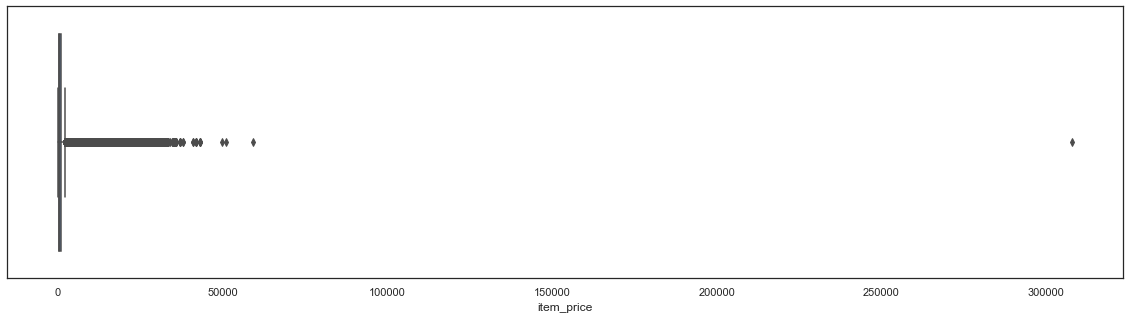

In [13]:
fig = plt.figure(figsize=(20, 5))
sns.boxplot(sales_train['item_price'])
plt.show()

We can't use the same reasoning as before, because it's usual that most of items are bought at a low price.

In [14]:
print(len(sales_train[sales_train['item_price'] <= 0]), "rows in data have negative values")

1 rows in data have negative values


In [15]:
sales_train = sales_train[sales_train['item_price'] > 0]

In [16]:
whis = 1.5
IQR = sales_train['item_price'].quantile(0.75) - sales_train['item_price'].quantile(0.25)
outliers = sales_train[sales_train['item_price'] > sales_train['item_price'].quantile(0.75) + IQR*whis]

topn = 10
print("Top", topn, "items by price they were sold are:")
topn_outliers = outliers.sort_values('item_price', ascending=False)[:topn].join(
    items.drop('item_category_id', axis=1), on='item_id')[['item_id', 'item_price', 'item_name']]
topn_outliers

Top 10 items by price they were sold are:


,item_id,item_price,item_name
1163158,6066,307980.0,Radmin 3 - 522 лиц.
885138,11365,59200.0,Доставка (EMS)
1488135,13199,50999.0,Коллекционные шахматы (Властелин Колец)
2327159,7241,49782.0,UserGate Proxy & Firewall 6.X с модулем фильтр...
2910156,13403,42990.0,"Комплект ""Microsoft Xbox One 1TB Limited Edit..."
2917760,13403,42990.0,"Комплект ""Microsoft Xbox One 1TB Limited Edit..."
2885692,13403,42990.0,"Комплект ""Microsoft Xbox One 1TB Limited Edit..."
2931380,13403,42990.0,"Комплект ""Microsoft Xbox One 1TB Limited Edit..."
1006638,7238,42000.0,UserGate Proxy & Firewall 6.X до 100 сессий
2913267,13403,41990.0,"Комплект ""Microsoft Xbox One 1TB Limited Edit..."


Let's dig just a bit in what is happening. For instance, Radmin 3 is a software for remote support, system administartion and so on and it is not an coincidence that 522 copies of it cost so much. It is an outlier. Let's drop such items which don't meet in "test" and have price more then sertain treshold.

In [17]:
outliers = outliers[outliers['item_id'].isin(test['item_id'].unique()) == False]
outliers = outliers[outliers['item_price'] >= 30000]

indexes = outliers.index
sales_train.drop(indexes, inplace=True)

# 2.Data incompleteness
It looks like the "1" value of "item_cnt_day" still dominates dataset, but is it a real truth? What about 0? \

Let's collect assortment of each shop and add records with 0 sales for each item in it. When we calculate "target" value, some of these records will no longer exist (as some items were sold), but others will show the lack of sales. \

P.S. \
Assortment can change in real life, but let's say that it caonstant for the whole abservation period

In [26]:
assortment = sales_train.groupby('shop_id')['item_id'].unique()
assortment = dict(zip(assortment.index, assortment.values))

In [33]:
item_records = 0
for i in shops.index:
    item_records += len(assortment[i])
print("We can add", item_records, "in our dataset for each month")
print("Size of our dataset is", len(sales_train))

We can add 424108 in our dataset for each month
Size of our dataset is 2935796


Looks to heavy, so let's include only random part of it.

In [124]:
# Attention: long proccessing
sample_size = 100
sp = []
for shop_id in shops.index:
    for date_block_num in range(34):
        shop_records = pd.DataFrame(assortment[shop_id], columns=['item_id'])
        shop_records['shop_id'], shop_records['date_block_num'], shop_records['item_cnt_day']  = shop_id, date_block_num, 0
        shop_records.reindex(columns=['date_block_num', 'shop_id', 'item_id', 'item_cnt_day'])
        
        # Choose random sample for each shop and each data_block_num
        indexes = len(shop_records.values.tolist())
        sp += shop_records.iloc[np.random.choice(indexes, sample_size, replace=False)].values.tolist()
        
full_addiction = pd.DataFrame(sp, columns=['date_block_num', 'shop_id', 'item_id', 'item_cnt_day'])

In [125]:
pd.concat([sales_train.drop(['date', 'item_category_id', 'item_price'], axis=1), full_addiction]).groupby(
    ['date_block_num', 'shop_id', 'item_id', 'item_cnt_day'])['item_cnt_day'].sum().shape

(1997622,)

# 3. Sales' story

In [ ]:
sales_train['date'] = pd.to_datetime(sales_train['date'])
sales_train = sales_train.sort_values('date')

# 4. Additional feature engineering

In [4]:
# Parameters
items_sample_size = 50

# Include items and shops only from test
test_shops = test['shop_id'].unique()
test_items = test['item_id'].unique()

data = sales_train[
    sales_train['shop_id'].isin(test_shops) & 
    sales_train['item_id'].isin(test_items)].copy()

# Collect item prices (taking into account that prices should not differ much from shop to shop)
prices = sales_train.groupby(['item_id'])[['item_price']].mean()
data.drop('item_price', axis = 1, inplace = True)

# Drop column "date", which is not going to be used
data.drop('date', axis = 1, inplace = True)

# Get rid of mistakes in selection
data = data[data['item_cnt_day'] >= 0]

# If an item is not sold, our model should predict this fact
sp = []
for item in np.random.choice(test_items, items_sample_size, replace=False):
    for date_block in range(34):
        for shop in test_shops:
            sp.append([date_block, shop, item, 0])
zero_sales = pd.DataFrame(sp, columns = data.columns)
data = pd.concat([data, zero_sales])

# Making "target" values
data = data.groupby(["date_block_num", "shop_id", "item_id"])['item_cnt_day'].sum().reset_index()
data.rename(columns = {'item_cnt_day' : 'target'}, inplace=True)
data.loc[:, ('target')] = data['target'].astype('int32')

# Add categories' info
data = data.join(items.set_index('item_id')['item_category_id'], on='item_id')
data = data.join(prices, on=['item_id'])

# Change test to a format of "data" variable
build_test = test.join(items.set_index('item_id')['item_category_id'], on='item_id')
build_test = build_test.join(prices, on='item_id')
build_test.drop('ID', axis=1, inplace=True)

# Add "date_block_num" information
build_test['date_block_num'] = 34
build_test = build_test.reindex(columns=["date_block_num"] + list(build_test.columns)[:-1])

In [260]:
print('\"Radmin 3\" item was bought', len(sales_train[sales_train['item_id'] == 6066]), 'times')

"Radmin 3" item was bought 0 times


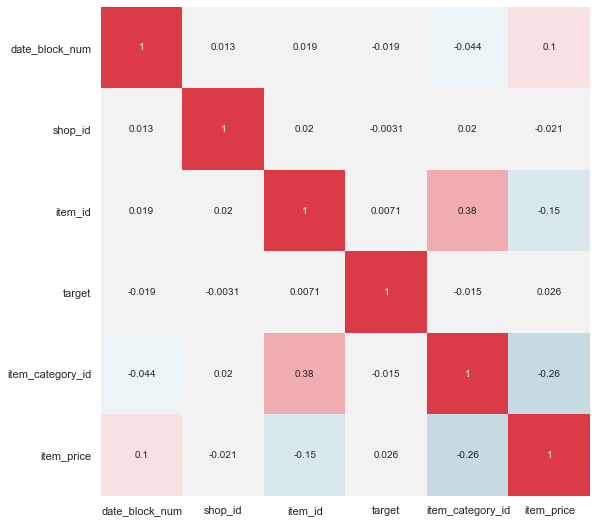

In [8]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, center = 0.,
            cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            annot=True, cbar=False, square=True)

plt.yticks(rotation = 0)
plt.xticks(rotation = 0)
    
plt.show()

Let's conider the following format of data (conditions for the work of the code below): \
**Columns** : shop_id - item_id - item_category_id - item_price \
shop_id, item_id, item_category_id can't have NaNs \
item_price can have NaNs

In [19]:
# This function makes features which depend on a part of known dataset, such as mean values
# Also it doesn't matter if "test_input" has "target" column (for validation) or not (for the real test)
def preparation(data_input, test_input, mean_encoding, indexes_union_for_dummies):  
    data_train = data_input.copy()
    data_train.loc[:, 'item_price'].fillna(data_train['item_price'].mean(), inplace=True)

    data_test = test_input.copy()
    data_test.loc[:, 'item_price'].fillna(data_train['item_price'].mean(), inplace=True)
    
    # Mean encoding
    for column in mean_encoding:
        collect_means = data_train.groupby(column)[['target']].mean()
        collect_means.rename(columns = {'target' : 'mean_' + column}, inplace=True)

        data_train = data_train.join(collect_means, on=column)
        data_test = data_test.join(collect_means, on=column)
        data_test = data_test.fillna(method='ffill', axis=1)
       
    # One Hot encoding
    for column in list(indexes_union_for_dummies.keys()):
        ids_union = indexes_union_for_dummies[column]
        data_train.loc[:, column] = data_train[column].astype(pd.CategoricalDtype(categories=ids_union))
        data_test.loc[:, column] = data_test[column].astype(pd.CategoricalDtype(categories=ids_union))

        data_train = data_train.join(pd.get_dummies(data_train[column], prefix=column))
        data_test = data_test.join(pd.get_dummies(data_test[column], prefix=column))

        data_train.drop(column, axis=1, inplace=True)
        data_test.drop(column, axis=1, inplace=True)
        
    return data_train, data_test

#### Approach 0: Linear Regression

In [56]:
kf5 = KFold(n_splits = 5, shuffle=True)
indexes_union_for_dummies = dict()
mean_encoding =  []

for train_index, test_index in kf5.split(data):
    data_train, data_test = preparation(data.loc[train_index], data.loc[test_index], mean_encoding, indexes_union_for_dummies)
    
    X_train, X_test = data_train.drop('target', axis = 1), data_test.drop('target', axis = 1)
    y_train, y_test = data_train['target'].astype('float32'), data_test['target'].astype('float32')
    
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    print(metrics.mean_squared_error(y_test, lr.predict(X_test)))

104.9424183467713
109.95931521177557
142.80673025987474
113.93789702529644
104.41515470788808


#### Approach 1 : Mean encoding, Linear Regression

In [57]:
kf5 = KFold(n_splits = 5, shuffle=True)
indexes_union_for_dummies = dict()
mean_encoding =  ['shop_id', 'item_id', 'item_category_id']

for train_index, test_index in kf5.split(data):
    data_train, data_test = preparation(data.loc[train_index], data.loc[test_index], mean_encoding, indexes_union_for_dummies)
    
    X_train, X_test = data_train.drop('target', axis = 1), data_test.drop('target', axis = 1)
    y_train, y_test = data_train['target'].astype('float32'), data_test['target'].astype('float32')
    
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    print(metrics.mean_squared_error(y_test, lr.predict(X_test)))

75.9559944797769
79.74611194506095
60.093020590337574
103.83677194208866
59.1070037994563


#### Approach 2 : Mean encoding, One Hot encoding, Linear Regression

In [20]:
kf5 = KFold(n_splits = 5, shuffle=True)
indexes_union_for_dummies = dict()
mean_encoding =  ['shop_id', 'item_id', 'item_category_id']
for column in ['shop_id', 'item_category_id']:
    indexes_union_for_dummies[column] = list(set(build_test[column].unique().tolist()).union(set(data[column].unique().tolist())))

for train_index, test_index in kf5.split(data):
    data_train, data_test = preparation(data.loc[train_index], data.loc[test_index], mean_encoding, indexes_union_for_dummies)
    
    X_train, X_test = data_train.drop('target', axis = 1), data_test.drop('target', axis = 1)
    y_train, y_test = data_train['target'].astype('float32'), data_test['target'].astype('float32')
    
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    print(metrics.mean_squared_error(y_test, lr.predict(X_test)))

97.12592194538212
50.254617465669334
67.21406253718759
85.40748603954867
77.5712757397218


So I have chosen approach N

In [54]:
mean_encoding =  ['shop_id', 'item_id', 'item_category_id']
for column in ['shop_id', 'item_category_id']:
    indexes_union_for_dummies[column] = list(set(build_test[column].unique().tolist()).union(set(data[column].unique().tolist())))
    
data_train, data_test = preparation(data, build_test, mean_encoding, indexes_union_for_dummies)

lr = linear_model.LinearRegression()
lr.fit(data_train.drop('target', axis = 1), data_train['target'].astype('float32'))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [55]:
submission = pd.DataFrame(lr.predict(data_test))

submission.index.name = 'ID'
submission.columns = ['item_cnt_month']

submission.to_csv('./results/submbission.csv')